# Mammography Data

# 50% of minority class

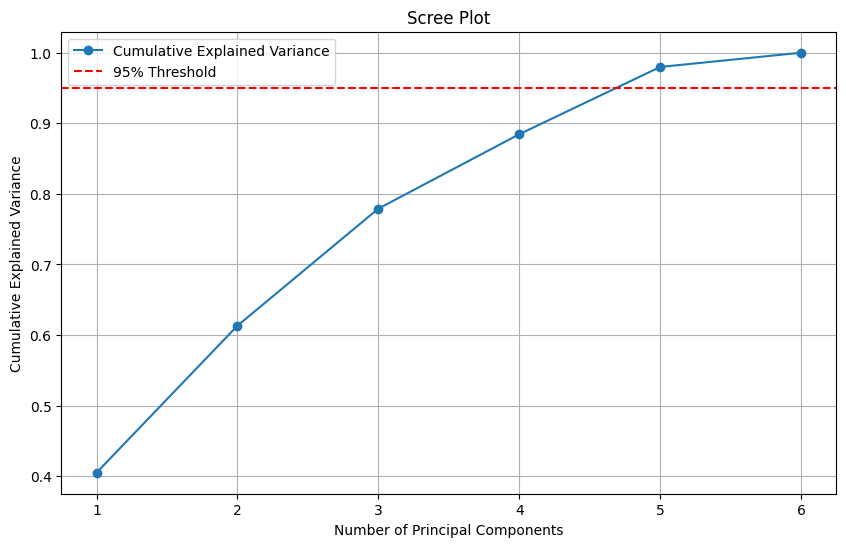

Optimal number of components: 5
Class distribution before augmentation: Counter({-1: 10923, 1: 260})
Class distribution after augmentation: Counter({-1: 10923, 1: 390})


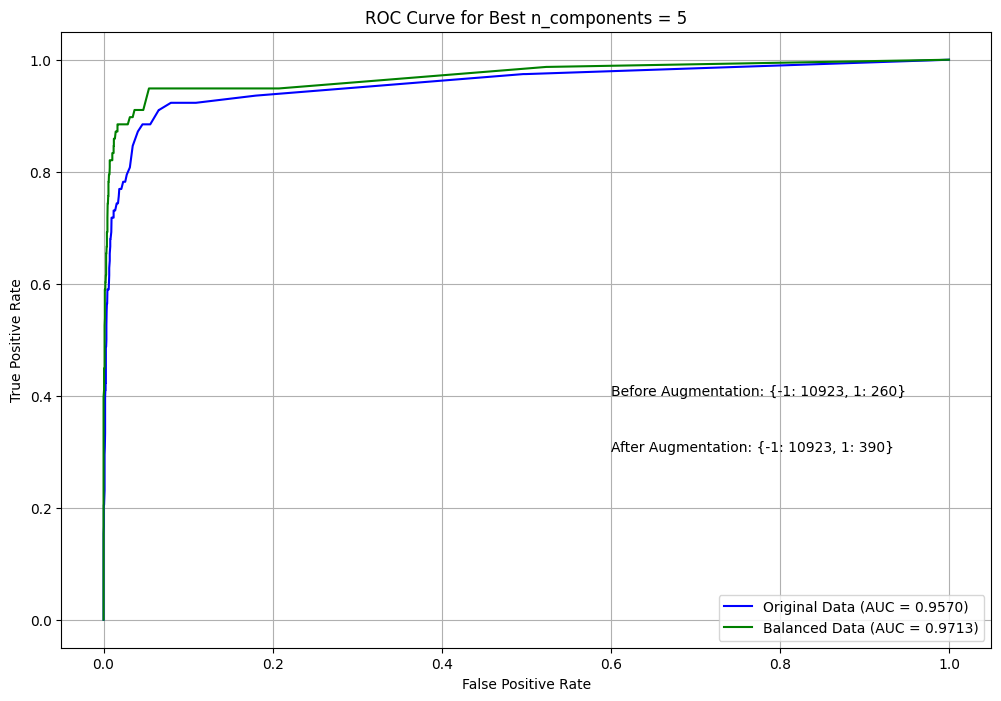


Results:
Recall (Original Data): 0.4872
Recall (Balanced Data): 0.7564

Classification Report (Original Data):
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      3277
           1       0.81      0.49      0.61        78

    accuracy                           0.99      3355
   macro avg       0.90      0.74      0.80      3355
weighted avg       0.98      0.99      0.98      3355


Classification Report (Balanced Data):
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99      3277
           1       0.76      0.76      0.76        78

    accuracy                           0.99      3355
   macro avg       0.88      0.88      0.88      3355
weighted avg       0.99      0.99      0.99      3355



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('mammography_dataset.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced) // 2
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# 100% of minority class

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('mammography_dataset.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the number of features and limit for PCA components
n_features = X.shape[1]
max_n_components = min(10, n_features)

# Initialize variables to store results
max_recall_balanced = 0
best_n_component_balanced = 0
best_classification_report_original = ""
best_classification_report_balanced = ""
best_roc_original = ([], [])
best_roc_balanced = ([], [])
best_auc_original = 0
best_auc_balanced = 0

# Iterate over n_components for PCA
for n_components in range(2, max_n_components + 1):
    print(f"Evaluating for PCA n_components = {n_components}")

    # Reduce dimensionality using PCA
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_scaled)

    # Step 4: Split the dataset into train and test (30% test data)
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

    # Step 5: Train a Random Forest classifier on the original dataset
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate recall on the original test set
    y_pred = rf.predict(X_test)
    recall_original = recall_score(y_test, y_pred)
    classification_report_original = classification_report(y_test, y_pred)

    # Calculate ROC curve and AUC for original data
    fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
    auc_original = auc(fpr_original, tpr_original)

    # Step 6: Identify the minority class
    class_counts = Counter(y)
    minority_class = min(class_counts, key=class_counts.get)

    print("Class distribution before augmentation:", class_counts)

    # Step 7: Use ForestDiffusionModel to generate synthetic samples for the minority class
    X_minority_reduced = X_reduced[y == minority_class]

    forest_model = ForestDiffusionModel(
        X_minority_reduced,
        label_y=None,
        n_t=50,
        duplicate_K=100,
        bin_indexes=[],       # No binary columns in latent space
        cat_indexes=[],       # No categorical columns in latent space
        int_indexes=[],       # No integer columns in latent space
        diffusion_type='flow',
        n_jobs=-1
    )

    # Generate synthetic samples in latent space
    num_samples_to_generate = len(X_minority_reduced) 
    generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

    # Step 8: Add synthetic data to the original data in latent space
    X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
    y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

    class_counts_after = Counter(y_balanced)
    print("Class distribution after augmentation:", class_counts_after)

    # Step 9: Split the balanced dataset into train and test and classify again
    X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
        X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

    # Train a Random Forest classifier on the balanced dataset
    rf_bal = RandomForestClassifier(random_state=42)
    rf_bal.fit(X_train_balanced, y_train_balanced)

    # Predict and evaluate recall on the balanced test set
    y_pred_balanced = rf_bal.predict(X_test)
    recall_balanced = recall_score(y_test, y_pred_balanced)
    classification_report_balanced = classification_report(y_test, y_pred_balanced)

    # Calculate ROC curve and AUC for balanced data
    fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
    auc_balanced = auc(fpr_balanced, tpr_balanced)

    # Update maximum recall for balanced data
    if recall_balanced > max_recall_balanced:
        max_recall_balanced = recall_balanced
        best_n_component_balanced = n_components
        best_classification_report_original = classification_report_original
        best_classification_report_balanced = classification_report_balanced
        best_roc_original = (fpr_original, tpr_original)
        best_roc_balanced = (fpr_balanced, tpr_balanced)
        best_auc_original = auc_original
        best_auc_balanced = auc_balanced

    print(f"Recall (Original): {recall_original:.4f}, Recall (Balanced): {recall_balanced:.4f}")

# Plot the ROC curves for the best n_components
plt.figure(figsize=(12, 8))
plt.plot(best_roc_original[0], best_roc_original[1], label=f'Original Data (AUC = {best_auc_original:.4f})', color='blue')
plt.plot(best_roc_balanced[0], best_roc_balanced[1], label=f'Balanced Data (AUC = {best_auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_component_balanced}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nBest Results:")
print(f"Maximum Recall (Balanced Data): {max_recall_balanced:.4f} with n_components = {best_n_component_balanced}")
print("\nClassification Report (Original Data):")
print(best_classification_report_original)
print("\nClassification Report (Balanced Data):")
print(best_classification_report_balanced)


# 100% of minority class

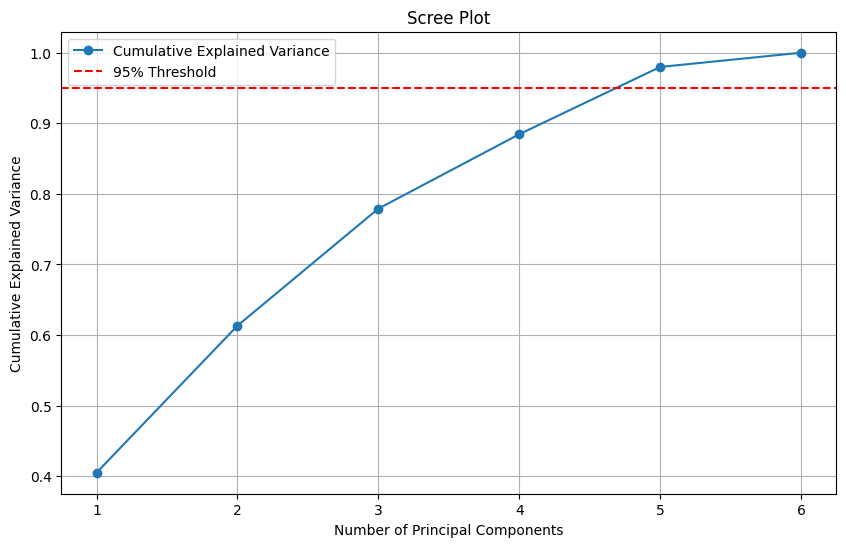

Optimal number of components: 5
Class distribution before augmentation: Counter({-1: 10923, 1: 260})
Class distribution after augmentation: Counter({-1: 10923, 1: 520})


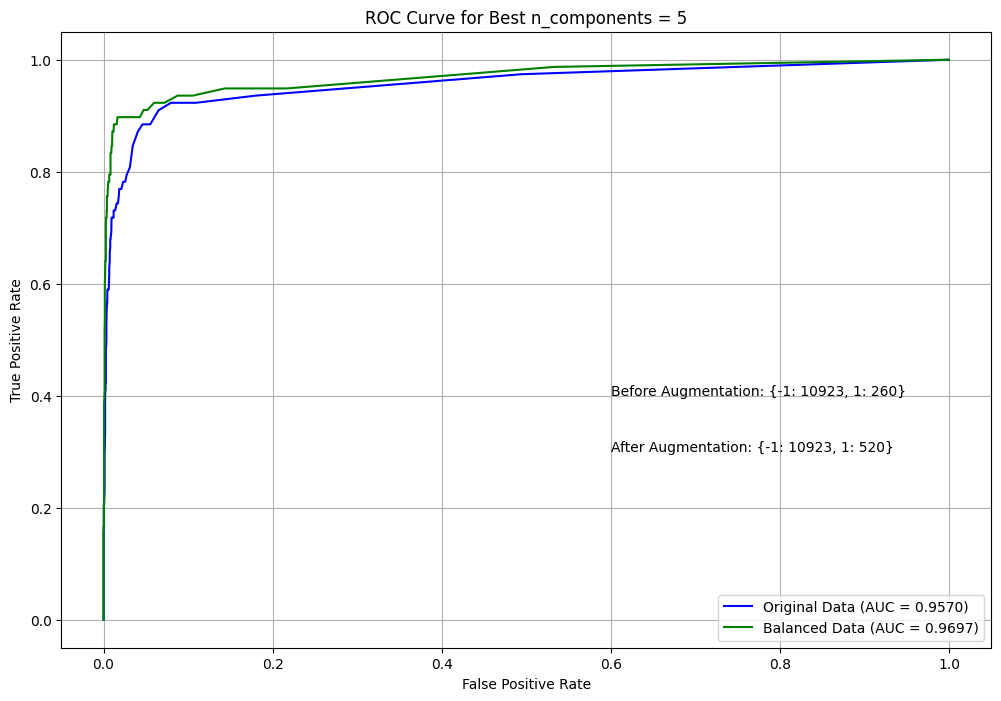


Results:
Recall (Original Data): 0.4872
Recall (Balanced Data): 0.7821

Classification Report (Original Data):
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      3277
           1       0.81      0.49      0.61        78

    accuracy                           0.99      3355
   macro avg       0.90      0.74      0.80      3355
weighted avg       0.98      0.99      0.98      3355


Classification Report (Balanced Data):
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99      3277
           1       0.74      0.78      0.76        78

    accuracy                           0.99      3355
   macro avg       0.87      0.89      0.88      3355
weighted avg       0.99      0.99      0.99      3355



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('mammography_dataset.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced) 
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# 200% of minority class

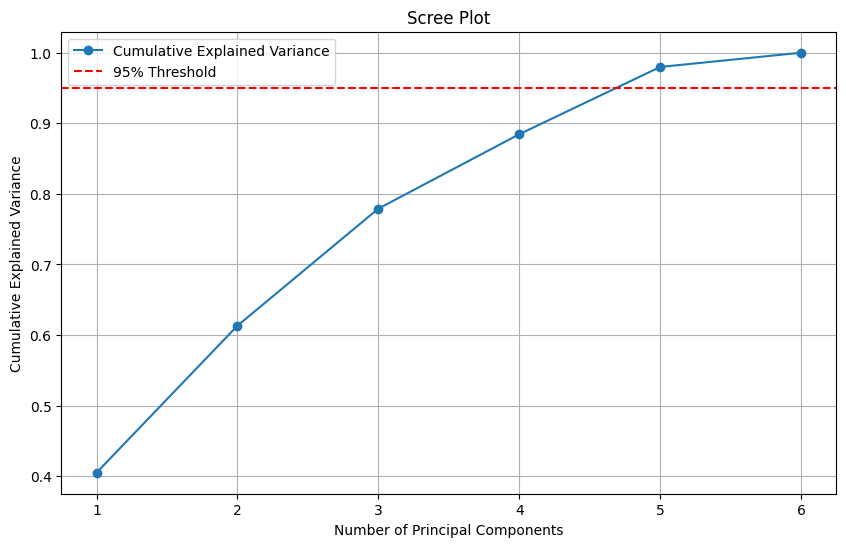

Optimal number of components: 5
Class distribution before augmentation: Counter({-1: 10923, 1: 260})
Class distribution after augmentation: Counter({-1: 10923, 1: 780})


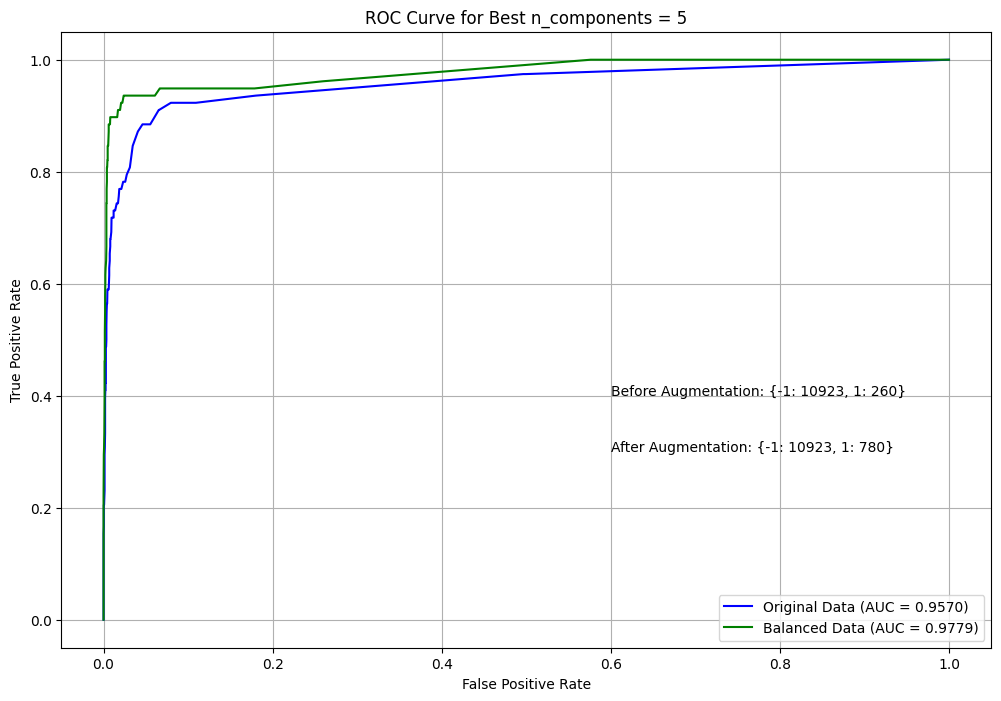


Results:
Recall (Original Data): 0.4872
Recall (Balanced Data): 0.8846

Classification Report (Original Data):
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      3277
           1       0.81      0.49      0.61        78

    accuracy                           0.99      3355
   macro avg       0.90      0.74      0.80      3355
weighted avg       0.98      0.99      0.98      3355


Classification Report (Balanced Data):
              precision    recall  f1-score   support

          -1       1.00      0.99      1.00      3277
           1       0.76      0.88      0.82        78

    accuracy                           0.99      3355
   macro avg       0.88      0.94      0.91      3355
weighted avg       0.99      0.99      0.99      3355



In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('mammography_dataset.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced) * 2
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# Spambase Data

# 50% of minority class

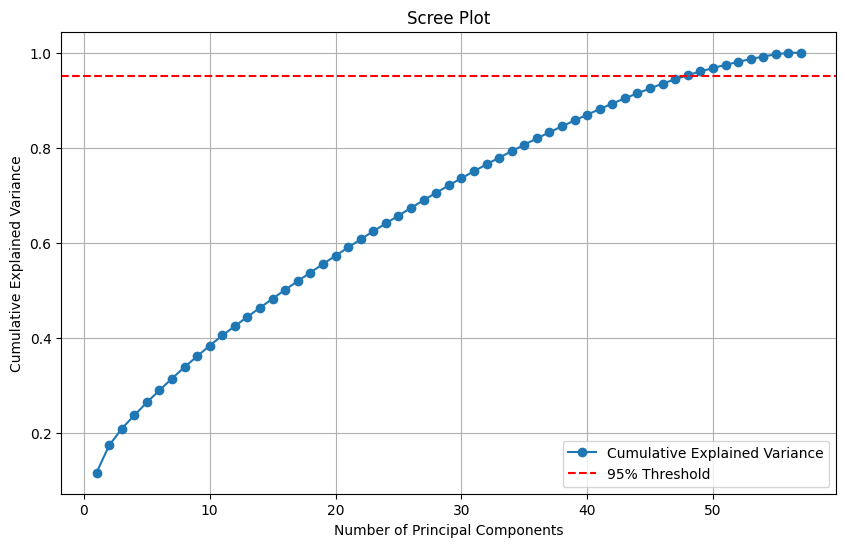

Optimal number of components: 48
Class distribution before augmentation: Counter({0: 2788, 1: 1813})
Class distribution after augmentation: Counter({0: 2788, 1: 2719})


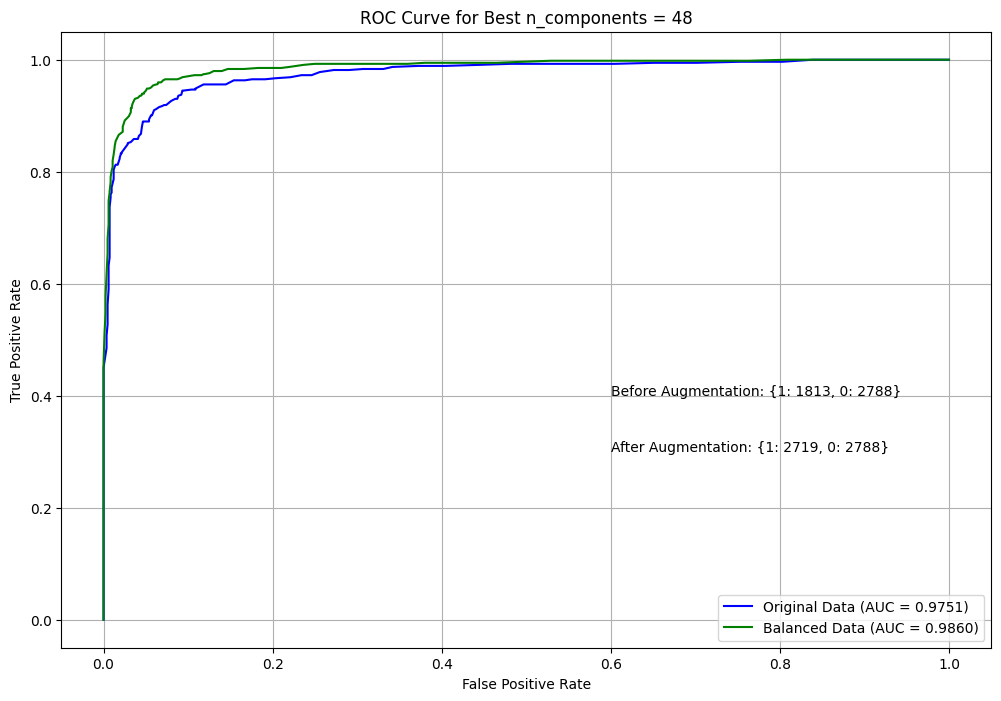


Results:
Recall (Original Data): 0.8971
Recall (Balanced Data): 0.9596

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       837
           1       0.91      0.90      0.91       544

    accuracy                           0.93      1381
   macro avg       0.92      0.92      0.92      1381
weighted avg       0.93      0.93      0.93      1381


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       837
           1       0.91      0.96      0.93       544

    accuracy                           0.94      1381
   macro avg       0.94      0.95      0.94      1381
weighted avg       0.95      0.94      0.95      1381



In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('Spambase.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced) // 2
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# 100% of minority class

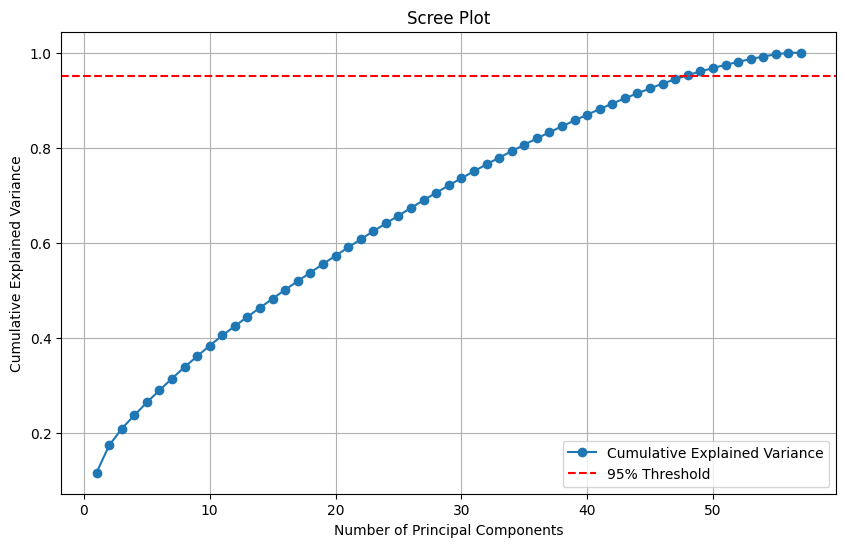

Optimal number of components: 48
Class distribution before augmentation: Counter({0: 2788, 1: 1813})
Class distribution after augmentation: Counter({1: 3626, 0: 2788})


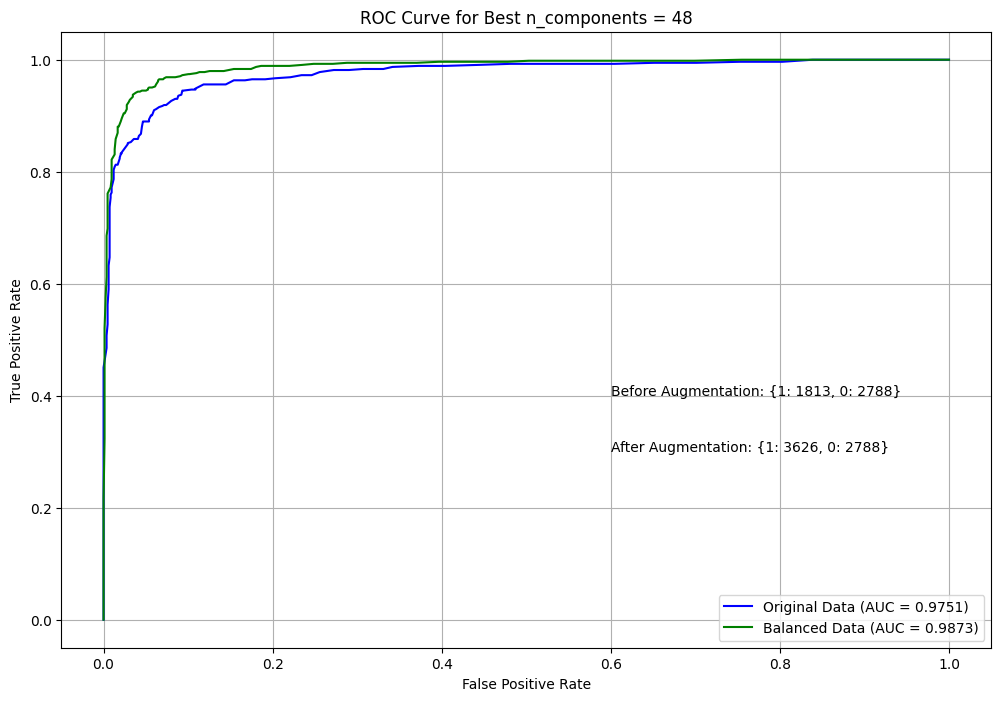


Results:
Recall (Original Data): 0.8971
Recall (Balanced Data): 0.9669

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       837
           1       0.91      0.90      0.91       544

    accuracy                           0.93      1381
   macro avg       0.92      0.92      0.92      1381
weighted avg       0.93      0.93      0.93      1381


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       837
           1       0.90      0.97      0.93       544

    accuracy                           0.94      1381
   macro avg       0.94      0.95      0.94      1381
weighted avg       0.95      0.94      0.94      1381



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('Spambase.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced) 
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# 200% of minority class

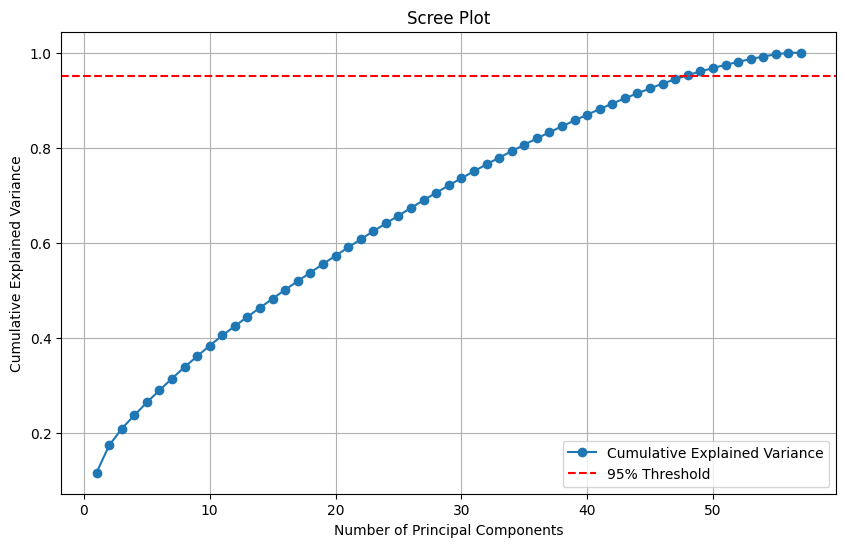

Optimal number of components: 48
Class distribution before augmentation: Counter({0: 2788, 1: 1813})
Class distribution after augmentation: Counter({1: 5439, 0: 2788})


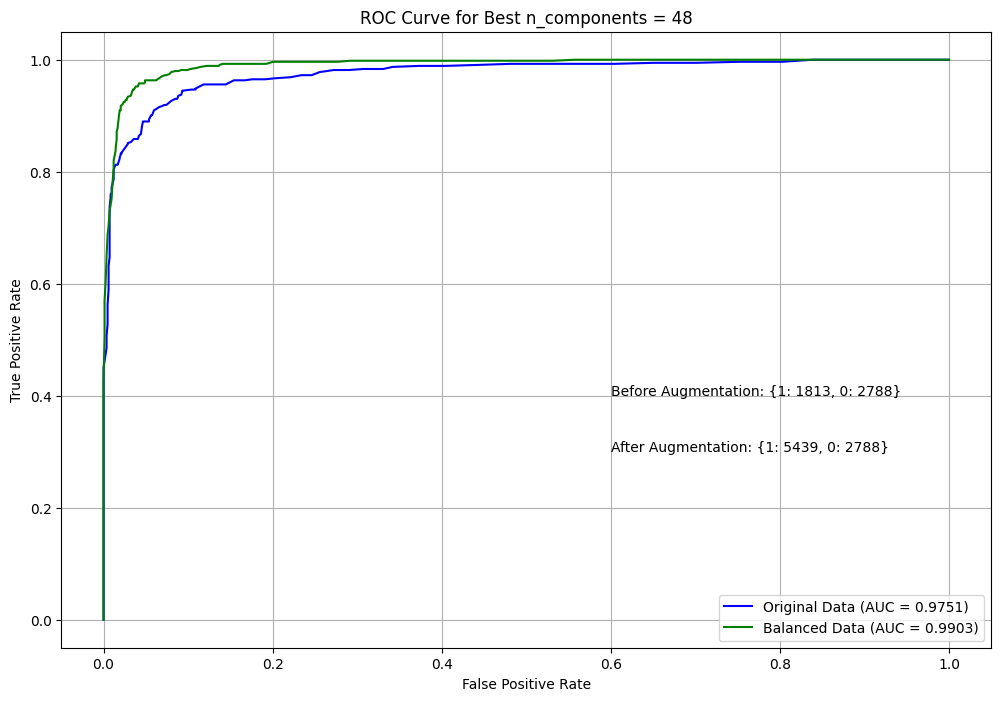


Results:
Recall (Original Data): 0.8971
Recall (Balanced Data): 0.9798

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       837
           1       0.91      0.90      0.91       544

    accuracy                           0.93      1381
   macro avg       0.92      0.92      0.92      1381
weighted avg       0.93      0.93      0.93      1381


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       837
           1       0.88      0.98      0.93       544

    accuracy                           0.94      1381
   macro avg       0.93      0.95      0.94      1381
weighted avg       0.94      0.94      0.94      1381



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('Spambase.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced) * 2
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# Reduced Spambase data. (minority:1000, previous: 1833)

# 50% of minority class

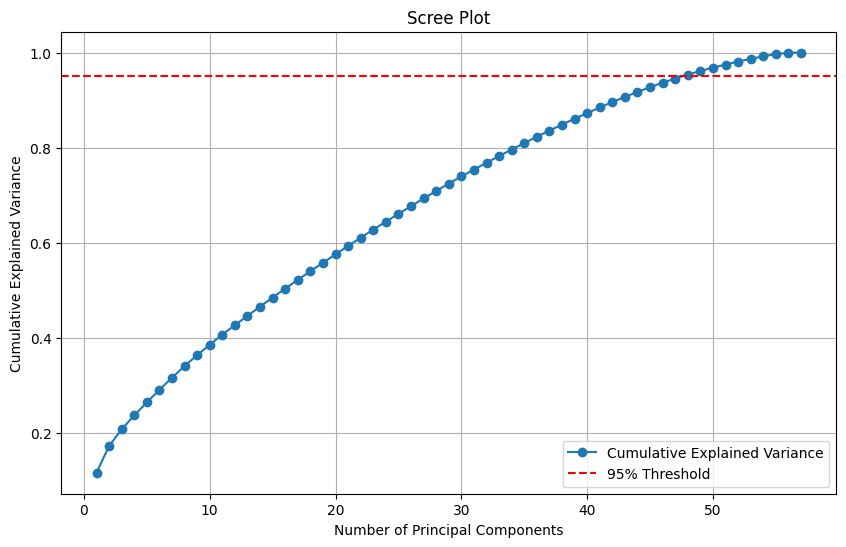

Optimal number of components: 48
Class distribution before augmentation: Counter({0: 2788, 1: 1000})
Class distribution after augmentation: Counter({0: 2788, 1: 1500})


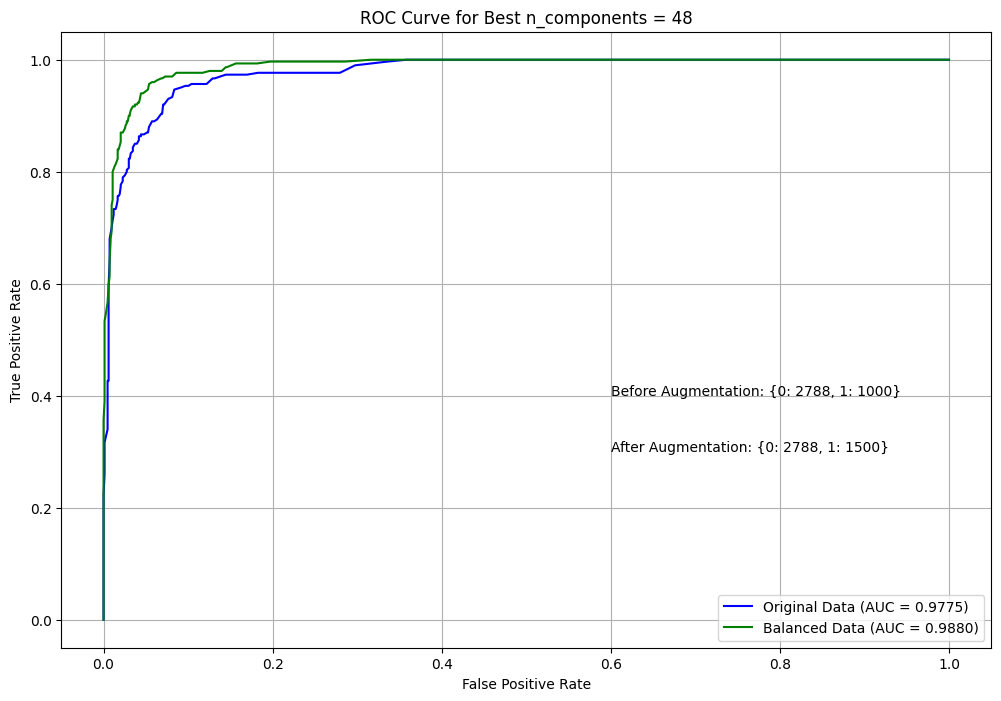


Results:
Recall (Original Data): 0.8400
Recall (Balanced Data): 0.9167

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       837
           1       0.90      0.84      0.87       300

    accuracy                           0.93      1137
   macro avg       0.92      0.90      0.91      1137
weighted avg       0.93      0.93      0.93      1137


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       837
           1       0.90      0.92      0.91       300

    accuracy                           0.95      1137
   macro avg       0.93      0.94      0.94      1137
weighted avg       0.95      0.95      0.95      1137



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('Spambase.csv')

# Separate the minority and majority classes
minority_class = data[data.iloc[:, -1] == 1]  # Rows where the last column (target) is 1
majority_class = data[data.iloc[:, -1] == 0]  # Rows where the last column (target) is 0

# Randomly select 813 samples to drop from the minority class
drop_indices = np.random.choice(minority_class.index, 813, replace=False)
minority_class = minority_class.drop(drop_indices)

# Combine the modified minority class and the majority class
balanced_data = pd.concat([majority_class, minority_class])

# Shuffle the dataset to ensure randomness
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into X and y
X = balanced_data.iloc[:, :-1]  # All columns except the last
y = balanced_data.iloc[:, -1]   # The last column

# Step 1: Load the data
#data = pd.read_csv('Spambase.csv')
#X = data.iloc[:, :-1]  # Features (assuming target is the last column)
#y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced) //2
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# 100% of minority class

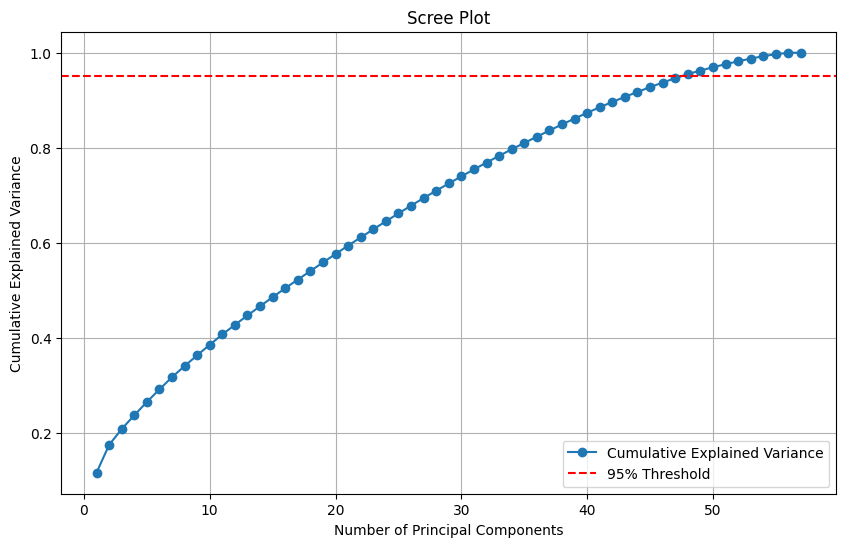

Optimal number of components: 48
Class distribution before augmentation: Counter({0: 2788, 1: 1000})
Class distribution after augmentation: Counter({0: 2788, 1: 2000})


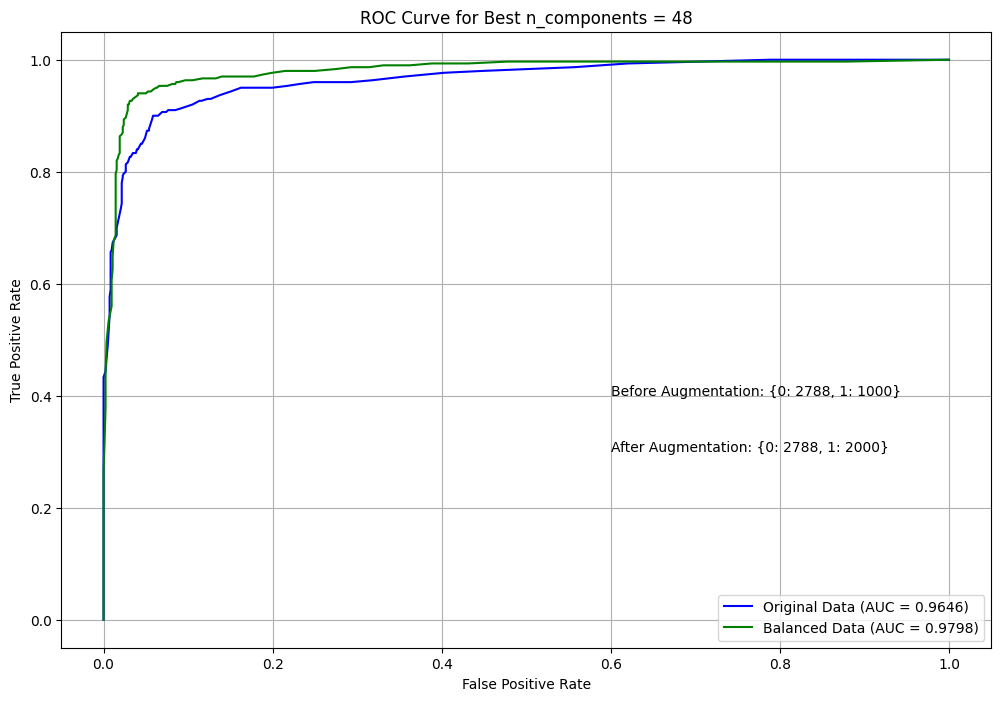


Results:
Recall (Original Data): 0.8333
Recall (Balanced Data): 0.9300

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       837
           1       0.90      0.83      0.86       300

    accuracy                           0.93      1137
   macro avg       0.92      0.90      0.91      1137
weighted avg       0.93      0.93      0.93      1137


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       837
           1       0.91      0.93      0.92       300

    accuracy                           0.96      1137
   macro avg       0.94      0.95      0.94      1137
weighted avg       0.96      0.96      0.96      1137



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('Spambase.csv')

# Separate the minority and majority classes
minority_class = data[data.iloc[:, -1] == 1]  # Rows where the last column (target) is 1
majority_class = data[data.iloc[:, -1] == 0]  # Rows where the last column (target) is 0

# Randomly select 813 samples to drop from the minority class
drop_indices = np.random.choice(minority_class.index, 813, replace=False)
minority_class = minority_class.drop(drop_indices)

# Combine the modified minority class and the majority class
balanced_data = pd.concat([majority_class, minority_class])

# Shuffle the dataset to ensure randomness
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into X and y
X = balanced_data.iloc[:, :-1]  # All columns except the last
y = balanced_data.iloc[:, -1]   # The last column

# Step 1: Load the data
#data = pd.read_csv('Spambase.csv')
#X = data.iloc[:, :-1]  # Features (assuming target is the last column)
#y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced) 
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# 200% of minority class

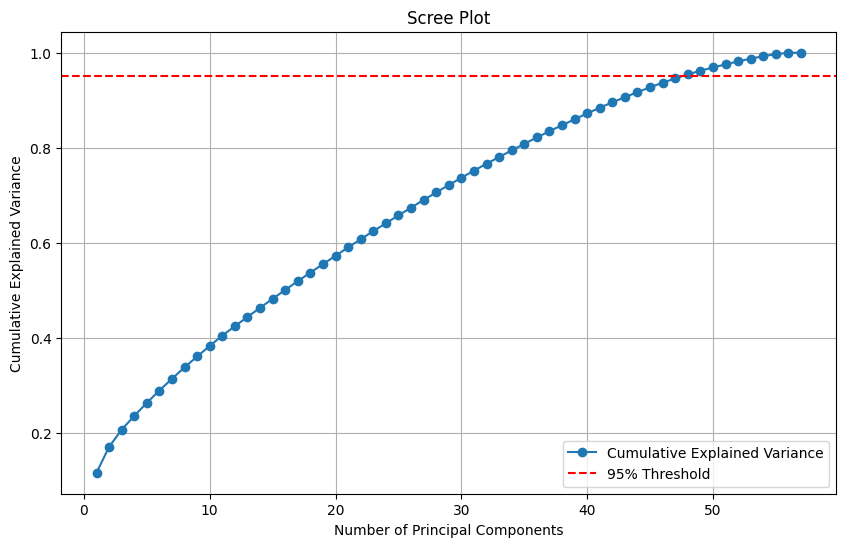

Optimal number of components: 48
Class distribution before augmentation: Counter({0: 2788, 1: 1000})
Class distribution after augmentation: Counter({1: 3000, 0: 2788})


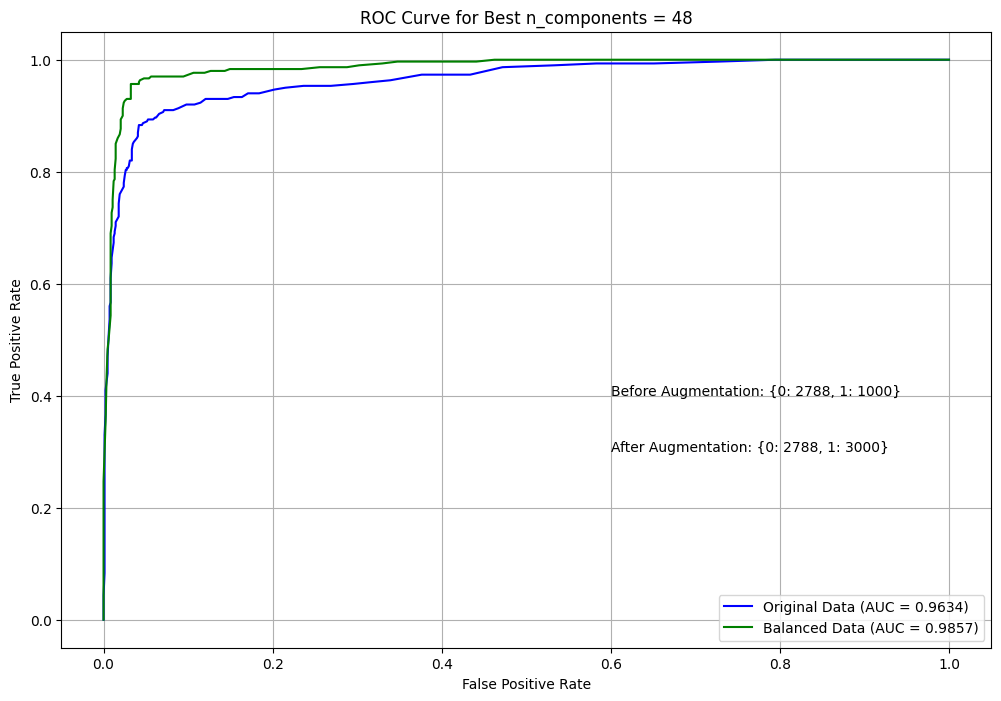


Results:
Recall (Original Data): 0.8200
Recall (Balanced Data): 0.9600

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       837
           1       0.90      0.82      0.86       300

    accuracy                           0.93      1137
   macro avg       0.92      0.89      0.91      1137
weighted avg       0.93      0.93      0.93      1137


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       837
           1       0.89      0.96      0.92       300

    accuracy                           0.96      1137
   macro avg       0.94      0.96      0.95      1137
weighted avg       0.96      0.96      0.96      1137



In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('Spambase.csv')

# Separate the minority and majority classes
minority_class = data[data.iloc[:, -1] == 1]  # Rows where the last column (target) is 1
majority_class = data[data.iloc[:, -1] == 0]  # Rows where the last column (target) is 0

# Randomly select 813 samples to drop from the minority class
drop_indices = np.random.choice(minority_class.index, 813, replace=False)
minority_class = minority_class.drop(drop_indices)

# Combine the modified minority class and the majority class
balanced_data = pd.concat([majority_class, minority_class])

# Shuffle the dataset to ensure randomness
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into X and y
X = balanced_data.iloc[:, :-1]  # All columns except the last
y = balanced_data.iloc[:, -1]   # The last column

# Step 1: Load the data
#data = pd.read_csv('Spambase.csv')
#X = data.iloc[:, :-1]  # Features (assuming target is the last column)
#y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced) * 2
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# Pulsar Data (HTRU_2)

# 50% of minority class

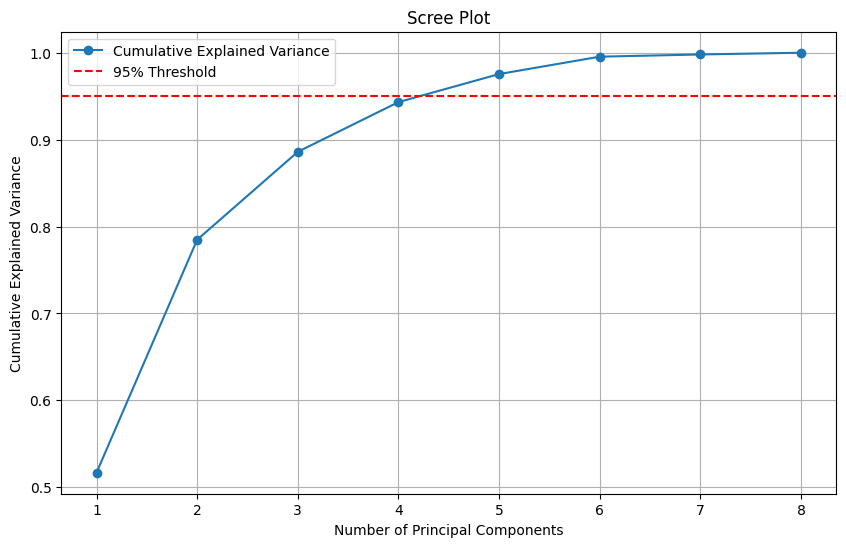

Optimal number of components: 5
Class distribution before augmentation: Counter({0: 16258, 1: 1639})
Class distribution after augmentation: Counter({0: 16258, 1: 2458})


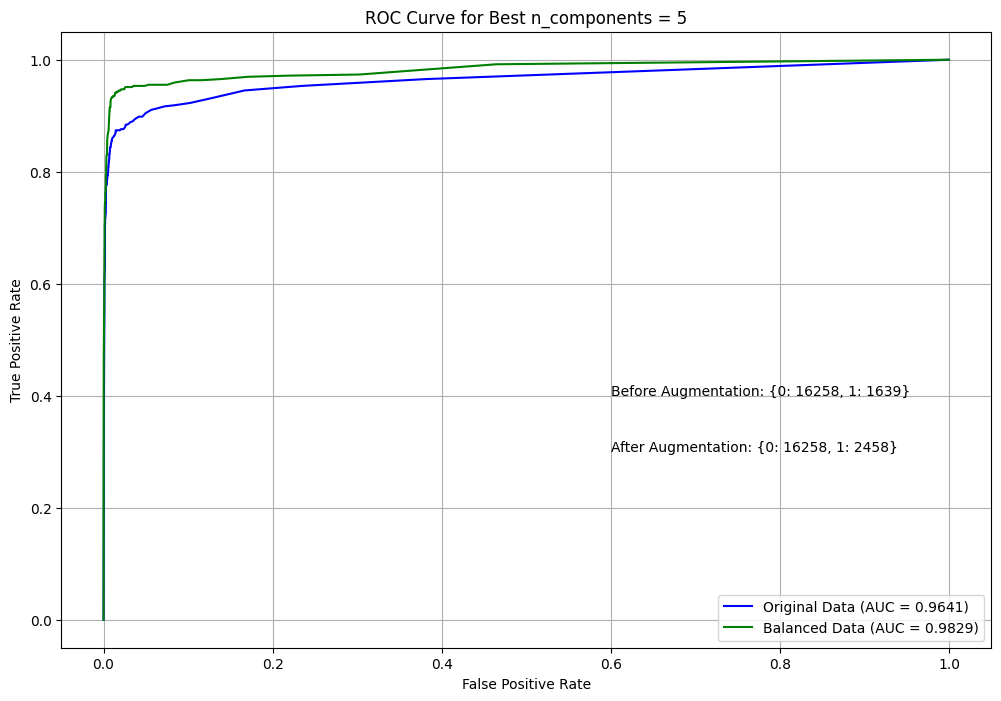


Results:
Recall (Original Data): 0.8313
Recall (Balanced Data): 0.9167

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4878
           1       0.93      0.83      0.88       492

    accuracy                           0.98      5370
   macro avg       0.95      0.91      0.93      5370
weighted avg       0.98      0.98      0.98      5370


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4878
           1       0.92      0.92      0.92       492

    accuracy                           0.98      5370
   macro avg       0.96      0.95      0.95      5370
weighted avg       0.98      0.98      0.98      5370



In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('HTRU_2.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced)//2
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# 100% of minority class

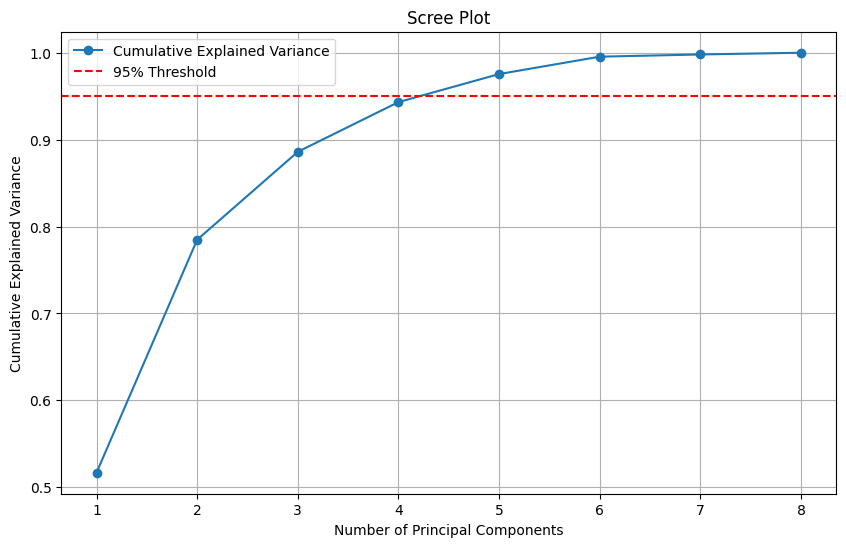

Optimal number of components: 5
Class distribution before augmentation: Counter({0: 16258, 1: 1639})
Class distribution after augmentation: Counter({0: 16258, 1: 3278})


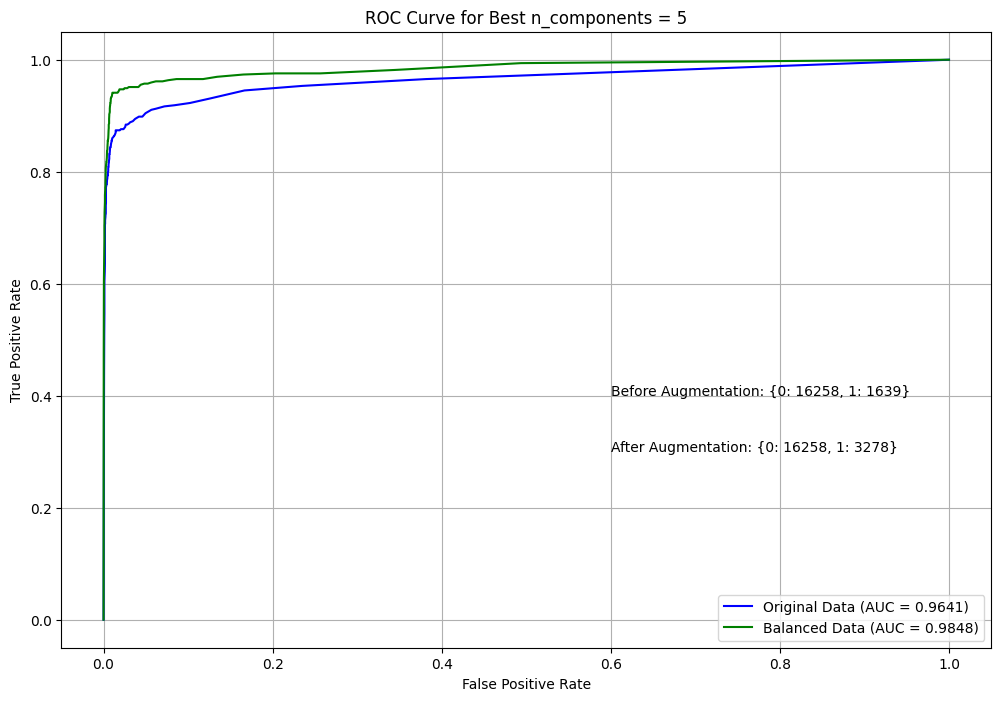


Results:
Recall (Original Data): 0.8313
Recall (Balanced Data): 0.9329

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4878
           1       0.93      0.83      0.88       492

    accuracy                           0.98      5370
   macro avg       0.95      0.91      0.93      5370
weighted avg       0.98      0.98      0.98      5370


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4878
           1       0.91      0.93      0.92       492

    accuracy                           0.99      5370
   macro avg       0.95      0.96      0.96      5370
weighted avg       0.99      0.99      0.99      5370



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('HTRU_2.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced)
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# 200% of minority class

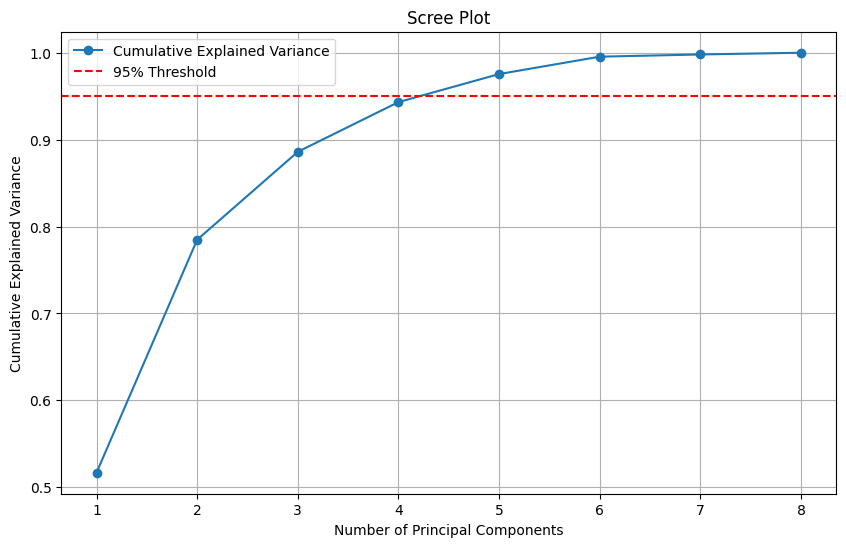

Optimal number of components: 5
Class distribution before augmentation: Counter({0: 16258, 1: 1639})
Class distribution after augmentation: Counter({0: 16258, 1: 4917})


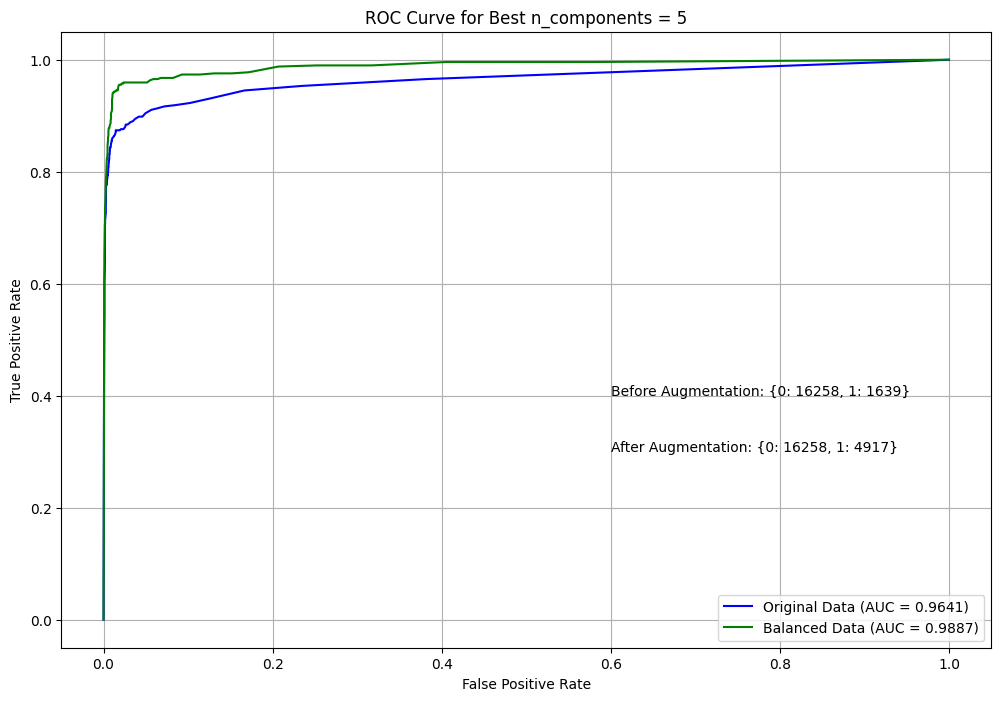


Results:
Recall (Original Data): 0.8313
Recall (Balanced Data): 0.9451

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4878
           1       0.93      0.83      0.88       492

    accuracy                           0.98      5370
   macro avg       0.95      0.91      0.93      5370
weighted avg       0.98      0.98      0.98      5370


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4878
           1       0.86      0.95      0.90       492

    accuracy                           0.98      5370
   macro avg       0.93      0.96      0.95      5370
weighted avg       0.98      0.98      0.98      5370



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('HTRU_2.csv')
X = data.iloc[:, :-1]  # Features (assuming target is the last column)
y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA and determine the optimal number of components using the Scree Method
pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

# Find the optimal number of components
best_n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Optimal number of components: {best_n_components}")

# Step 4: Reduce dimensionality using the optimal number of components
pca = PCA(n_components=best_n_components)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Split the dataset into train and test (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train a Random Forest classifier on the original dataset
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate recall on the original test set
y_pred = rf.predict(X_test)
recall_original = recall_score(y_test, y_pred)
classification_report_original = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC for original data
fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
auc_original = auc(fpr_original, tpr_original)

# Step 7: Identify the minority class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
print("Class distribution before augmentation:", class_counts)

# Step 8: Use ForestDiffusionModel to generate synthetic samples for the minority class
X_minority_reduced = X_reduced[y == minority_class]

forest_model = ForestDiffusionModel(
    X_minority_reduced,
    label_y=None,
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],       # No binary columns in latent space
    cat_indexes=[],       # No categorical columns in latent space
    int_indexes=[],       # No integer columns in latent space
    diffusion_type='flow',
    n_jobs=-1
)

# Generate synthetic samples in latent space
num_samples_to_generate = len(X_minority_reduced)*2
generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

# Step 9: Add synthetic data to the original data in latent space
X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

class_counts_after = Counter(y_balanced)
print("Class distribution after augmentation:", class_counts_after)

# Step 10: Split the balanced dataset into train and test and classify again
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Train a Random Forest classifier on the balanced dataset
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate recall on the balanced test set
y_pred_balanced = rf_bal.predict(X_test)
recall_balanced = recall_score(y_test, y_pred_balanced)
classification_report_balanced = classification_report(y_test, y_pred_balanced)

# Calculate ROC curve and AUC for balanced data
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_original, tpr_original, label=f'Original Data (AUC = {auc_original:.4f})', color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Data (AUC = {auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_components}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nResults:")
print(f"Recall (Original Data): {recall_original:.4f}")
print(f"Recall (Balanced Data): {recall_balanced:.4f}")
print("\nClassification Report (Original Data):")
print(classification_report_original)
print("\nClassification Report (Balanced Data):")
print(classification_report_balanced)


# Pima Indians Diabetes (Reduced minority, minority: 200)

# 50% of minority

Class distribution after balancing:
Outcome
0    500
1    200
Name: count, dtype: int64

Shape of X: (700, 8)
Shape of y: (700,)
Evaluating for PCA n_components = 2
Class distribution before augmentation: Counter({0: 500, 1: 200})
Class distribution after augmentation: Counter({0: 500, 1: 300})
Recall (Original): 0.4000, Recall (Balanced): 0.7333
Evaluating for PCA n_components = 3
Class distribution before augmentation: Counter({0: 500, 1: 200})
Class distribution after augmentation: Counter({0: 500, 1: 300})
Recall (Original): 0.4000, Recall (Balanced): 0.6833
Evaluating for PCA n_components = 4
Class distribution before augmentation: Counter({0: 500, 1: 200})
Class distribution after augmentation: Counter({0: 500, 1: 300})
Recall (Original): 0.4667, Recall (Balanced): 0.6833
Evaluating for PCA n_components = 5
Class distribution before augmentation: Counter({0: 500, 1: 200})
Class distribution after augmentation: Counter({0: 500, 1: 300})
Recall (Original): 0.4667, Recall (Balanced)

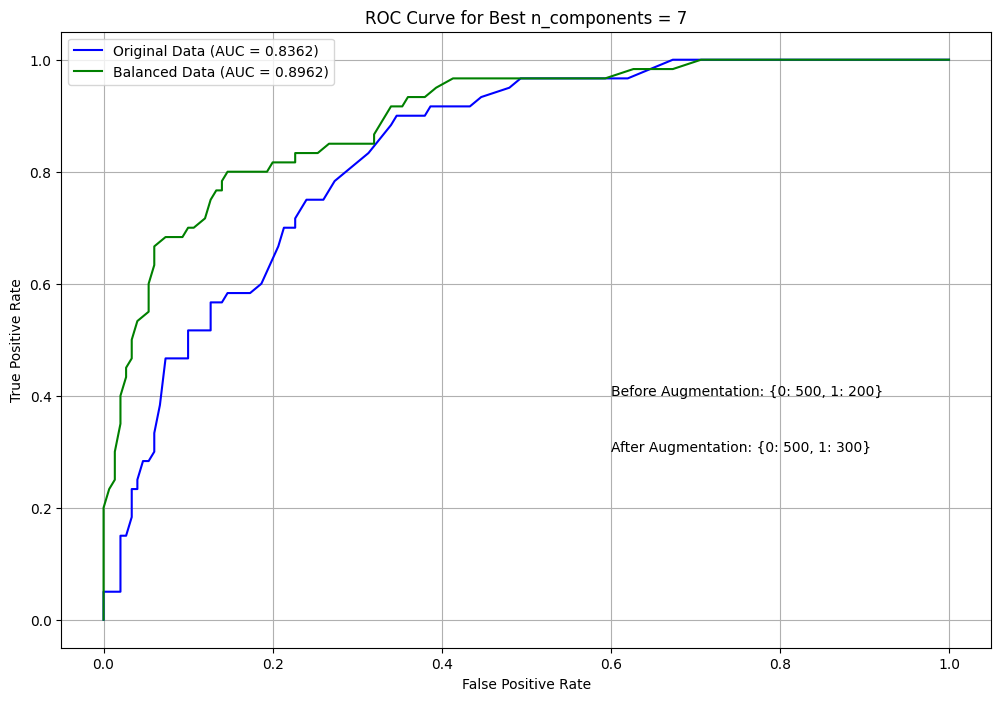


Best Results:
Maximum Recall (Balanced Data): 0.8000 with n_components = 7

Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       150
           1       0.64      0.57      0.60        60

    accuracy                           0.79       210
   macro avg       0.74      0.72      0.73       210
weighted avg       0.78      0.79      0.78       210


Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       150
           1       0.62      0.80      0.70        60

    accuracy                           0.80       210
   macro avg       0.77      0.80      0.78       210
weighted avg       0.83      0.80      0.81       210



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, recall_score
from collections import Counter
from sklearn.decomposition import PCA
from ForestDiffusion import ForestDiffusionModel
import matplotlib.pyplot as plt


# Load dataset
data = pd.read_csv("diabetes.csv")

# Separate the minority and majority classes
minority_class = data[data['Outcome'] == 1]
majority_class = data[data['Outcome'] == 0]

# Randomly sample 68 rows to drop from the minority class
minority_class_reduced = minority_class.sample(n=len(minority_class) - 68, random_state=42)

# Combine the reduced minority class with the majority class
balanced_data = pd.concat([majority_class, minority_class_reduced])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into X (features) and y (target)
X = balanced_data.drop(columns=['Outcome'])  # Drop the target column to get features
y = balanced_data['Outcome']  # Target variable

# Print results
print("Class distribution after balancing:")
print(balanced_data['Outcome'].value_counts())
print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)


#X = data.iloc[:, :-1]  # Features (assuming target is the last column)
#y = data.iloc[:, -1]  # Target

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the number of features and limit for PCA components
n_features = X.shape[1]
max_n_components = min(10, n_features)

# Initialize variables to store results
max_recall_balanced = 0
best_n_component_balanced = 0
best_classification_report_original = ""
best_classification_report_balanced = ""
best_roc_original = ([], [])
best_roc_balanced = ([], [])
best_auc_original = 0
best_auc_balanced = 0

# Iterate over n_components for PCA
for n_components in range(2, max_n_components + 1):
    print(f"Evaluating for PCA n_components = {n_components}")

    # Reduce dimensionality using PCA
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_scaled)

    # Step 4: Split the dataset into train and test (30% test data)
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)

    # Step 5: Train a Random Forest classifier on the original dataset
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate recall on the original test set
    y_pred = rf.predict(X_test)
    recall_original = recall_score(y_test, y_pred)
    classification_report_original = classification_report(y_test, y_pred)

    # Calculate ROC curve and AUC for original data
    fpr_original, tpr_original, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
    auc_original = auc(fpr_original, tpr_original)

    # Step 6: Identify the minority class
    class_counts = Counter(y)
    minority_class = min(class_counts, key=class_counts.get)

    print("Class distribution before augmentation:", class_counts)

    # Step 7: Use ForestDiffusionModel to generate synthetic samples for the minority class
    X_minority_reduced = X_reduced[y == minority_class]

    forest_model = ForestDiffusionModel(
        X_minority_reduced,
        label_y=None,
        n_t=50,
        duplicate_K=100,
        bin_indexes=[],       # No binary columns in latent space
        cat_indexes=[],       # No categorical columns in latent space
        int_indexes=[],       # No integer columns in latent space
        diffusion_type='flow',
        n_jobs=-1
    )

    # Generate synthetic samples in latent space
    num_samples_to_generate = len(X_minority_reduced)//2
    generated_samples_reduced = forest_model.generate(batch_size=num_samples_to_generate)

    # Step 8: Add synthetic data to the original data in latent space
    X_balanced_reduced = np.vstack([X_reduced, generated_samples_reduced])
    y_balanced = np.hstack([y, [minority_class] * len(generated_samples_reduced)])

    class_counts_after = Counter(y_balanced)
    print("Class distribution after augmentation:", class_counts_after)

    # Step 9: Split the balanced dataset into train and test and classify again
    X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
        X_balanced_reduced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

    # Train a Random Forest classifier on the balanced dataset
    rf_bal = RandomForestClassifier(random_state=42)
    rf_bal.fit(X_train_balanced, y_train_balanced)

    # Predict and evaluate recall on the balanced test set
    y_pred_balanced = rf_bal.predict(X_test)
    recall_balanced = recall_score(y_test, y_pred_balanced)
    classification_report_balanced = classification_report(y_test, y_pred_balanced)

    # Calculate ROC curve and AUC for balanced data
    fpr_balanced, tpr_balanced, _ = roc_curve(y_test, rf_bal.predict_proba(X_test)[:, 1])
    auc_balanced = auc(fpr_balanced, tpr_balanced)

    # Update maximum recall for balanced data
    if recall_balanced > max_recall_balanced:
        max_recall_balanced = recall_balanced
        best_n_component_balanced = n_components
        best_classification_report_original = classification_report_original
        best_classification_report_balanced = classification_report_balanced
        best_roc_original = (fpr_original, tpr_original)
        best_roc_balanced = (fpr_balanced, tpr_balanced)
        best_auc_original = auc_original
        best_auc_balanced = auc_balanced

    print(f"Recall (Original): {recall_original:.4f}, Recall (Balanced): {recall_balanced:.4f}")

# Plot the ROC curves for the best n_components
plt.figure(figsize=(12, 8))
plt.plot(best_roc_original[0], best_roc_original[1], label=f'Original Data (AUC = {best_auc_original:.4f})', color='blue')
plt.plot(best_roc_balanced[0], best_roc_balanced[1], label=f'Balanced Data (AUC = {best_auc_balanced:.4f})', color='green')
plt.title(f"ROC Curve for Best n_components = {best_n_component_balanced}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Add class distributions as text on the plot
plt.text(0.6, 0.4, f"Before Augmentation: {dict(class_counts)}", fontsize=10, color='black')
plt.text(0.6, 0.3, f"After Augmentation: {dict(class_counts_after)}", fontsize=10, color='black')
plt.show()

# Output the best results
print("\nBest Results:")
print(f"Maximum Recall (Balanced Data): {max_recall_balanced:.4f} with n_components = {best_n_component_balanced}")
print("\nClassification Report (Original Data):")
print(best_classification_report_original)
print("\nClassification Report (Balanced Data):")
print(best_classification_report_balanced)
